# Modelos preditivos para a área da Saúde

## Projeto 1: propensão a condição crítica de saúde

Desenvolvimento de um modelo de classificação para prever a situação crítica de saúde, com seleção de variáveis importantes. Usando uma base de dados com 50 mil casos, sendo estes os dados de [**Treino**](https://drive.google.com/file/d/1cBiizQ0ftP16dxqSQ8XVcf5oYIwEHkIU/view?usp=sharing) e de [**Teste**](https://drive.google.com/file/d/13AoBow1bEiAmmw9fqi0sv-QaoTciLiid/view?usp=sharing).

A avaliação do modelo foi feita em cima dos conjuntos de treino e teste, com base nas métricas de Área Sob a Curva ROC, Matriz de Confusão, Taxa do Alvo no Decil 10 e Taxa do Alvo no Percentil 100. 

Ao final, também é apresentada uma avaliação do modelo desenvolvido em um contexto de negócios.

In [63]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

Por limitações de tamanho no github, não subi os arquivos de treino. Mas eles estavam sob o path: '../datasets/health/'


In [64]:
# Obtendo dataset
train_path = '../datasets/health/train.gz'
test_path = '../datasets/health/test.gz'

train_data = pd.read_csv(train_path, compression='gzip')
test_data = pd.read_csv(test_path, compression='gzip')

## Análise exploratória dos dados
Observações:
 - Proporção treino e teste 80% e 20%, respectivamente.
 - Presença de missing values em todas as váriaveis (exceto na 'var1000'), proporcionais por váriavel nos dados de treino e teste. Porém, nenhuma coluna com mais de 50% de dados faltando.
 - Presença de desbalanceamento dos dados no dataset de treino, cerca de 86.41% de dados de clientes em situação não critica e apenas 13.58% de dados de clientes em situação crítica.

In [3]:
train_data.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var992,var993,var994,var995,var996,var997,var998,var999,var1000,alvo
0,2142.0,4397.0,8978.0,17329.0,25324.0,1515.0,3053.0,6295.0,12179.0,17714.0,...,0.00,0.00,0.00,0.00,0.00,0.00,3849.11,1.0,0,0
1,4230.0,8477.0,16253.0,31545.0,46576.0,3151.0,6286.0,12021.0,23391.0,34501.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,0
2,123016.0,253889.0,479469.0,949783.0,1423562.0,84625.0,173262.0,327248.0,648115.0,971543.0,...,2872.32,2872.32,1217.18,12423.70,21092.96,35177.31,66642.75,13.0,0,0
3,7646.0,15987.0,31309.0,60711.0,88139.0,5760.0,11899.0,23219.0,45452.0,66126.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,0
4,5442.0,10358.0,20710.0,40147.0,61672.0,1940.0,3900.0,7825.0,15161.0,22792.0,...,1045782.67,1645343.02,245300.63,514644.76,1628928.12,3211634.36,6019027.97,3940.0,0,0


In [4]:
test_data.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var992,var993,var994,var995,var996,var997,var998,var999,var1000,alvo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,0
1,1833.0,3745.0,3745.0,3745.0,3745.0,1314.0,2619.0,2619.0,2619.0,2619.0,...,0.00,0.00,199.33,944.33,1602.42,1602.42,1602.42,3.0,0,0
2,5077.0,10747.0,19337.0,35050.0,49748.0,3740.0,7885.0,14069.0,25651.0,36413.0,...,0.00,0.00,0.00,0.00,0.00,4925.56,4925.56,1.0,0,0
3,6145.0,12540.0,24752.0,49255.0,73599.0,3120.0,6436.0,12530.0,24554.0,36307.0,...,957.44,24444.31,0.00,0.00,0.00,123870.68,193836.09,40.0,0,0
4,12766.0,25627.0,41590.0,41590.0,41590.0,8516.0,17013.0,27721.0,27721.0,27721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 1001 entries, var1 to alvo
dtypes: float64(999), int64(2)
memory usage: 305.5 MB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 1001 entries, var1 to alvo
dtypes: float64(999), int64(2)
memory usage: 76.4 MB


In [11]:
train_data.isnull().sum().value_counts()

3363     653
2793     261
5262      30
7270      26
18418     12
13453      9
6491       4
9238       3
0          2
16686      1
dtype: int64

In [10]:
test_data.isnull().sum().value_counts()

826     653
693     261
1287     30
1825     26
4671     12
3394      9
1609      4
2297      3
0         2
4158      1
dtype: int64

In [5]:
train_data.describe()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var992,var993,var994,var995,var996,var997,var998,var999,var1000,alvo
count,36637.000000,36637.000000,36637.000000,3.663700e+04,3.663700e+04,36637.000000,36637.000000,36637.000000,36637.000000,3.663700e+04,...,3.473800e+04,3.473800e+04,3.473800e+04,3.473800e+04,3.473800e+04,3.473800e+04,3.473800e+04,34738.000000,40000.000000,40000.000000
mean,24804.687120,49974.286077,95779.201245,1.818178e+05,2.600089e+05,16658.785244,33521.751372,64056.096733,121855.235472,1.743171e+05,...,4.770847e+04,7.842249e+04,2.003598e+04,6.003429e+04,1.159118e+05,2.166463e+05,4.057985e+05,289.617710,0.135875,0.135875
std,44358.395291,89772.486759,171980.581801,3.309234e+05,4.809253e+05,30717.882674,61978.170719,118550.902344,229214.621624,3.337036e+05,...,2.494814e+05,3.922620e+05,8.813214e+04,2.492367e+05,4.767993e+05,8.833351e+05,1.663978e+06,1180.215142,0.342660,0.342660
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,3359.000000,6590.000000,12499.000000,2.365000e+04,2.820100e+04,1970.000000,4015.000000,7752.000000,14041.000000,1.971000e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.150250e+02,0.000000,0.000000,0.000000
50%,6143.000000,12265.000000,23529.000000,4.541100e+04,6.599600e+04,3208.000000,6348.000000,12454.000000,23916.000000,3.364300e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.976200e+02,2.729775e+03,7.455045e+03,3.000000,0.000000,0.000000
75%,10252.000000,20319.000000,39658.000000,7.639400e+04,1.097320e+05,6750.000000,13272.000000,25178.000000,47365.000000,6.765400e+04,...,2.872320e+03,7.180800e+03,7.190925e+02,4.255587e+03,1.028444e+04,2.067908e+04,4.031233e+04,14.000000,0.000000,0.000000
max,168919.000000,316033.000000,563161.000000,1.054178e+06,1.535014e+06,112720.000000,214210.000000,379438.000000,714427.000000,1.042131e+06,...,7.830240e+06,1.116868e+07,2.015612e+06,5.905256e+06,1.300342e+07,2.058648e+07,5.032083e+07,20502.000000,1.000000,1.000000


In [6]:
test_data.describe()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var992,var993,var994,var995,var996,var997,var998,var999,var1000,alvo
count,9174.000000,9174.000000,9174.000000,9.174000e+03,9.174000e+03,9174.000000,9174.000000,9174.000000,9174.000000,9.174000e+03,...,8.713000e+03,8.713000e+03,8.713000e+03,8.713000e+03,8.713000e+03,8.713000e+03,8.713000e+03,8713.000000,10000.000000,10000.000000
mean,24864.573578,50174.079355,95576.022346,1.809401e+05,2.582955e+05,16707.490517,33660.392522,63913.747002,121248.619468,1.731504e+05,...,4.616771e+04,7.549891e+04,1.942765e+04,5.794069e+04,1.108083e+05,2.054263e+05,3.862228e+05,273.882360,0.135900,0.135900
std,44469.720558,90183.189076,171736.914031,3.300074e+05,4.790643e+05,30806.337294,62239.910301,118328.888769,228504.537154,3.323184e+05,...,2.481162e+05,3.916968e+05,9.048858e+04,2.484163e+05,4.636473e+05,8.463317e+05,1.598387e+06,1135.406673,0.342699,0.342699
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,3359.500000,6590.000000,12519.000000,2.377100e+04,2.820100e+04,2000.000000,4072.000000,7752.000000,14442.000000,1.987900e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.475100e+02,0.000000,0.000000,0.000000
50%,6143.000000,12341.000000,23739.000000,4.542800e+04,6.618300e+04,3237.000000,6374.000000,12484.000000,24113.000000,3.416600e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.150000e+02,2.948350e+03,7.647040e+03,3.000000,0.000000,0.000000
75%,10291.000000,20363.000000,39496.000000,7.633675e+04,1.084432e+05,6750.000000,13940.000000,25187.000000,47410.750000,6.765200e+04,...,3.051780e+03,7.180800e+03,6.881100e+02,4.205480e+03,1.018238e+04,2.069721e+04,4.074355e+04,14.000000,0.000000,0.000000
max,168919.000000,316033.000000,563161.000000,1.054178e+06,1.535014e+06,112720.000000,214210.000000,379438.000000,714427.000000,1.042131e+06,...,5.717874e+06,1.075274e+07,2.015612e+06,4.872254e+06,9.299266e+06,1.809810e+07,3.569716e+07,16877.000000,1.000000,1.000000


In [20]:
grouped_target = train_data.groupby(train_data.alvo)
print(grouped_target.get_group(0).info())
print(grouped_target.get_group(1).info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34565 entries, 0 to 39999
Columns: 1001 entries, var1 to alvo
dtypes: float64(999), int64(2)
memory usage: 264.2 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5435 entries, 12 to 39993
Columns: 1001 entries, var1 to alvo
dtypes: float64(999), int64(2)
memory usage: 41.5 MB
None


## Pré-processamento das variáveis
Durante esta etapa, estarei lidando com o desbalanceamento dos dados de treino e o preenchimento de missing values

In [66]:
def preprocess(balance_train_fn, fill_missing_data_fn):
    new_train = fill_missing_data_fn(train_data)
    new_test = fill_missing_data_fn(test_data)
    balanced_train = balance_train_fn(new_train)

    train_y = balanced_train['alvo']
    test_y = new_test['alvo']
    train_X = balanced_train.drop('alvo', axis=1)
    test_X = new_test.drop('alvo', axis=1)
    return train_X, train_y, test_X, test_y


### Lidando com desbalanceamento de dados de treino
 - **Oversampling**: Replicando os dados da classe minoritária até que esteja maior ou igual ao da classe majoritária, e removendo o excesso no final para que tenham o mesmo tamanho
    - Escolhi usar esta abordagem com base no escopo e tempo do projeto, por ser uma abordagem **direta e rápida de ser executada**. Em outros contextos, abordagens como a coleta de mais dados da classe minoritária, ou geração de novos exemplos sintéticos poderiam ser úteis.

In [67]:
def oversampling(train):
    # Separação das classes
    grouped_target = train.groupby(train.alvo)
    non_critical = grouped_target.get_group(0)
    critical = grouped_target.get_group(1)

    # Duplicação da classe minoritaria
    while critical.shape[0] < non_critical.shape[0]:
        critical = pd.concat([critical,critical])
    critical = critical.iloc[:-(critical.shape[0]-non_critical.shape[0])]

    # Juntando as duas classes novamente e embaralhando
    train = pd.concat([non_critical, critical])
    train = train.sample(frac=1).reset_index(drop=True) 
    return train

### Preenchimento de missing values
 - **Imputação da média**: Inicialmente, selecionei este método por ser o mais rápido para iniciar os testes da seleção de features, apesar de estar ciente da desvantagem de impactar a variação no conjunto. 
 - **Imputação por KNN**: Tendo em mente as desvantagens da imputação da média, planejava substituir o preenchimento de missing values pelo KNN, por parecer ser mais robusto e manter melhor a variedade no conjunto. (**resultados com knn se encontram no arquivo HealthRiskClassificationKNN.ipynb**)

Entretanto os resultados com a imputação da média (apresentados no final deste arquivo) se mostraram bastante positivos, sendo suficientes e mais performático que a alternativa do KNN neste caso de estudo.

In [68]:
def fill_mean(data):
    df_filled = data.fillna(data.mean())
    return df_filled

In [69]:
def fill_kNN(data):
    imputer = KNNImputer(n_neighbors=5)
    filled = imputer.fit_transform(data)
    df_filled = pd.DataFrame(filled, columns = data.columns)
    return df_filled

In [70]:
train_X, train_y, test_X, test_y = preprocess(oversampling, fill_mean)

In [71]:
train_X.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var961,var962,var963,var964,var965,var966,var967,var968,var969,var1000
0,1821.0,3752.0,7270.0,13591.0,19438.0,1210.0,2542.0,4908.0,9140.0,12977.0,...,104699.0,77220.0,164405.0,367790.0,759094.0,7587.0,15736.0,83523.0,166236.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,138054.0,301391.0,563161.0,1054178.0,1535014.0,95285.0,206823.0,379438.0,714427.0,1042131.0,...,461095.0,373890.0,132.0,284.0,570.0,64074.0,128569.0,236784.0,478197.0,0
3,1657.0,3371.0,6758.0,13038.0,19148.0,1132.0,2303.0,4550.0,8736.0,12784.0,...,127303.0,93855.0,179939.0,374955.0,815917.0,8276.0,17167.0,83849.0,173892.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [72]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69130 entries, 0 to 69129
Columns: 915 entries, var1 to var1000
dtypes: float64(914), int64(1)
memory usage: 482.6 MB


## Seleção de features
 - **Recursive Feature Elimination (RFE)**: primeiramente tentei usar o RFE como algoritmo para seleção de features importantes, porém sua performance não pareceu ideal para o escopo do projeto (mais de 10h rodando usando juntamente com o modelo de Random Forest), então em paralelo busquei novas alternativas (resultados com RFE no arquivo "HealthRiskClassificationRFE0.ipynb")
 - **Obtendo Feature Importance em Modelos Ensemble**: Selecionei os algoritmos de Random Forest e Gradient Boosting, pois pela familiaridade que eu tenho com esses modelos e o entendimento que tive na analise do dataset, acreditei que seriam capazes de alcançar bons resultados.

In [73]:
def get_top_important_features(model):
    model.fit(train_X, train_y)

    # Obtendo as importâncias das variáveis
    importances = model.feature_importances_
    # Ordena as features importantes e filtra pelas importancias maiores que 0
    sorted_important_features = sorted(zip(train_X.columns, importances), key=lambda x: x[1], reverse=True)
    important_features_zip = filter(lambda x: x[1] > 0, sorted_important_features)

    # Obtem os nomes das 100 primeiras features, separando das respectivas importancias
    important_features = [x[0] for x in important_features_zip][:100]
    print(important_features)
    print(len(important_features))
    return important_features

In [74]:
# Separando 20% do dataset (25% do dataset de treino) para validação no Gradient Boosting
val_frac = 0.25

In [75]:
model_gb = GradientBoostingClassifier(validation_fraction=val_frac)
selected_features_gb = get_top_important_features(model_gb)

# Aplicando features importantes para o modelo gb
train_gb_X = train_X[selected_features_gb]

['var1000', 'var532', 'var672', 'var926', 'var784', 'var363', 'var728', 'var316', 'var622', 'var929', 'var198', 'var239', 'var530', 'var10', 'var913', 'var60', 'var321', 'var567', 'var689', 'var2', 'var686', 'var663', 'var611', 'var607', 'var300', 'var510', 'var940', 'var169', 'var620', 'var505', 'var961', 'var630', 'var535', 'var536', 'var653', 'var274', 'var632', 'var496']


In [80]:
model_rf = RandomForestClassifier()
selected_features_rf = get_top_important_features(model_rf)

# Aplicando features importantes para o modelo rf
train_rf_X = train_X[selected_features_rf]

['var1000', 'var457', 'var384', 'var397', 'var290', 'var437', 'var316', 'var271', 'var433', 'var425', 'var889', 'var356', 'var558', 'var398', 'var541', 'var516', 'var888', 'var475', 'var297', 'var616', 'var515', 'var532', 'var291', 'var289', 'var890', 'var511', 'var514', 'var429', 'var539', 'var538', 'var338', 'var615', 'var315', 'var346', 'var386', 'var272', 'var342', 'var512', 'var891', 'var556', 'var534', 'var254', 'var537', 'var265', 'var606', 'var286', 'var296', 'var319', 'var385', 'var298', 'var666', 'var617', 'var542', 'var427', 'var793', 'var269', 'var374', 'var267', 'var892', 'var294', 'var304', 'var287', 'var270', 'var557', 'var468', 'var505', 'var566', 'var546', 'var465', 'var545', 'var312', 'var561', 'var347', 'var301', 'var264', 'var491', 'var288', 'var260', 'var500', 'var320', 'var657', 'var919', 'var388', 'var313', 'var536', 'var531', 'var494', 'var868', 'var487', 'var449', 'var486', 'var517', 'var310', 'var258', 'var525', 'var555', 'var931', 'var58', 'var268', 'var535',

## Treinamento

In [76]:
model_gb.fit(train_gb_X, train_y)

GradientBoostingClassifier(validation_fraction=0.25)

In [81]:
model_rf.fit(train_rf_X, train_y)

RandomForestClassifier()

## Análise de resultados
Conclusão final: 

Ambos os modelos obtiveram resultados excepcionais, com um destaque especial no **Gradient Boosting**, que conseguiu classificar os dados de treino e teste com perfeição. Apesar disso, encontro esses resultados "perfeitos" com um certo ceticismo. A uniformidade dos dados de teste com relação aos de treino me levam a acreditar que talvez possa ter ocorrido um certo overfitting. Sendo esse o caso, esse modelo se beneficiaria de uma nova coleta de dados de teste, mais diversos para uma validação mais precisa, especialmente levando em conta que a natureza do problema envolve a identificação de situações de saúde crítica.

*(Análise mais aprofundadas dos modelos e suas respectivas métricas avaliadas a seguir)*

In [77]:
def print_confusion_matrix(cm):
  fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, figsize=(5, 5), cmap='Greys', show_absolute=True, show_normed=True)
  ax.set_title("Matriz de Confusão")
  plt.show()

In [100]:
def print_results(model, trans_train_X, trans_test_X):
    train_predict_proba = model.predict_proba(trans_train_X)[:, 1]
    test_predict_proba = model.predict_proba(trans_test_X)[:, 1]
    
    # Métrica: Área Sob a Curva ROC
    roc_auc_train = roc_auc_score(train_y, train_predict_proba)
    print("Área Sob a Curva ROC (Treino):", roc_auc_train)
    roc_auc_test = roc_auc_score(test_y, test_predict_proba)
    print("Área Sob a Curva ROC (Teste):", roc_auc_test)

    # Métrica: Matriz de Confusão
    train_cm = confusion_matrix(train_y, train_predict_proba > 0.5)
    print_confusion_matrix(train_cm)
    test_cm = confusion_matrix(test_y, test_predict_proba > 0.5)
    print_confusion_matrix(test_cm)

    # Cálculo da Taxa do Alvo no Decil 10 e Percentil 100
    sorted_test_score = np.argsort(test_predict_proba)[::-1]

    target_rate_decile_10 = np.mean(test_y[sorted_test_score[:len(test_y)//10]])
    print("Taxa do Alvo no Decil 10:", target_rate_decile_10)
    target_rate_percentile_100 = np.mean(test_y[sorted_test_score[:len(test_y)//100]])   
    print("Taxa do Alvo no Percentil 100:", target_rate_percentile_100)

### Resultados do Random Forest
 - **Área Sob a Curva ROC**: 
    - O Random Forest apresentou uma capacidade de separar as classes de 'alvo' com perfeição nos dados de treinamento, com uma área sob a curva ROC de 1.0. 
    - Além disso, o modelo obteve uma área sob a curva ROC próxima de 1.0 no conjunto de teste, e apesar de não ser perfeitamente 1, indica que ele generalizou bem e, em tese, será capaz de lidar com dados desconhecidos.
 - **Matriz de Confusão**: 
    - O Random Forest apresenta um desempenho perfeito na classificação das amostras de treinamento, mas tem algumas pequenas dificuldades na classificação das amostras de teste, contendo alguns falsos positivos e negativos.
    - Os resultados da matriz de teste indicam que há espaço para otimização dos hiperparametros de forma a melhorar a capacidade de generalização do modelo.
 - **Taxas do alvo no Decil 10 e no Percentil 100**: 
    - Ambas se apresentaram igualmente altas, com um valor de 1.0. Isso significa que o Random Forest foi altamente eficaz em identificar as amostras mais relevantes para a tarefa de classificação.

1.0
0.9826
Área Sob a Curva ROC (Treino): 1.0
Área Sob a Curva ROC (Teste): 0.9996747031176301


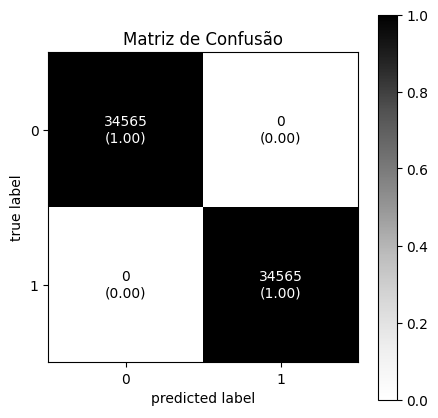

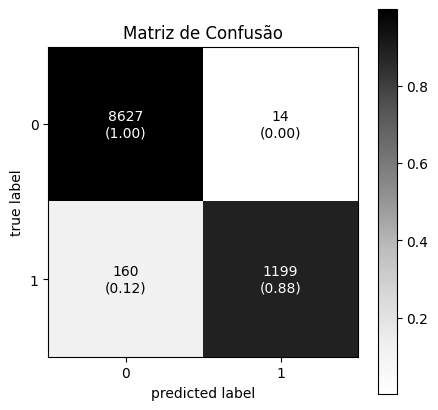

Taxa do Alvo no Decil 10: 1.0
Taxa do Alvo no Percentil 100: 1.0


In [102]:
test_rf_X = test_X[selected_features_rf]
print(model_rf.score(train_rf_X, train_y))
print(model_rf.score(test_rf_X, test_y))
print_results(model_rf, train_rf_X, test_rf_X)

### Resultados do Gradient Boosting
 - **Área Sob a Curva ROC**: 
    - O Gradient Boosting apresentou uma capacidade de separar as classes de 'alvo' com perfeição nos dados de treinamento e nos dados de teste, conforme indicado pelas áreas sob a curva ROC de 1.0. 
 - **Matriz de Confusão**: 
    - O Gradient Boosting apresenta um desempenho perfeito na classificação das amostras de treinamento e de teste. Indicando uma alta precisão e confiabilidade.
 - **Taxas do alvo no Decil 10 e no Percentil 100**: 
    - Ambas se apresentaram igualmente altas, com um valor de 1.0. Isso significa que o Gradient Boosting foi altamente eficaz em identificar as amostras mais relevantes para a tarefa de classificação.

Como o Gradient Boosting obteve resultados "perfeitos" com os hiperparametros padrões, não houve a necessidade de uma otimização dos hiperparametros. Porém, se esse não fosse o caso, seria possível utilizar bibliotecas como o optuna para fazer um estudo sobre e selecionar os melhores hiperparametros para n_estimators, learning_rate, max_depth, min_sample_split, e subsample.

1.0
1.0
Área Sob a Curva ROC (Treino): 1.0
Área Sob a Curva ROC (Teste): 1.0


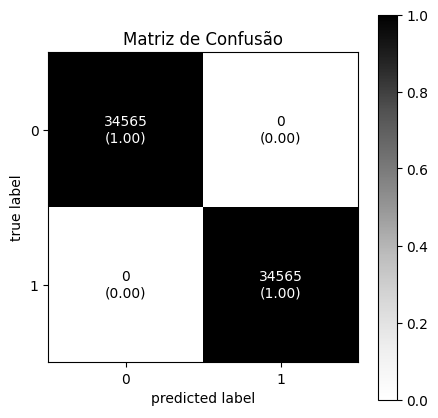

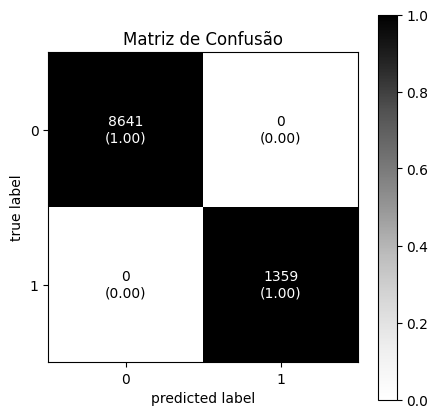

Taxa do Alvo no Decil 10: 1.0
Taxa do Alvo no Percentil 100: 1.0


In [101]:
test_gb_X = test_X[selected_features_gb]
print(model_gb.score(train_gb_X, train_y))
print(model_gb.score(test_gb_X, test_y))
print_results(model_gb, train_gb_X, test_gb_X)

## Análise de negócios

Os resultados obtidos pelo modelo desenvolvido foram extremamente positivos, com uma capacidade de não só impactar positivamente a empresa de saúde, mas também seus clientes.

Esse modelo tem a capacidade de facilitar imensamente os diagnósticos e identificação precoce de situações de saúde crítica, servindo até de redundância, ajudando a prevenir erro médico, e assim aumentando a segurança dos clientes.

Por meio da identificação precoce dessas situações, também será possível alocar eficientemente recursos médicos e financeiros, possibilitando uma otimização do uso de equipamentos, medicamentos e pessoal médico.

Se a empresa possuir ramos na área de pesquisa médica, esse modelo pode revelar correlações entre as variáveis e diagnósticos não descobertas até o momento, abrindo margens para publicações pioneiras.

Destacados esses pontos, fica claro que o modelo desenvolvido pode ser o diferencial para a empresa de saúde no mercado.